<h2>HUXt examples.</h2>

This notebook contains several examples of how to use the 1D and 2D versions of HUXt provided is this package, as described in Owens et al (2020).

In [1]:
import numpy as np
import HUXt as H
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2880621e160>)

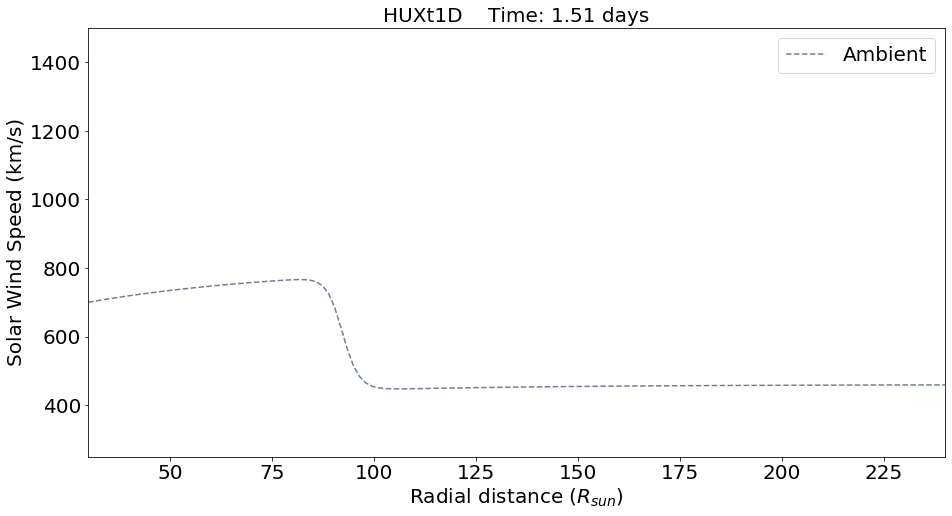

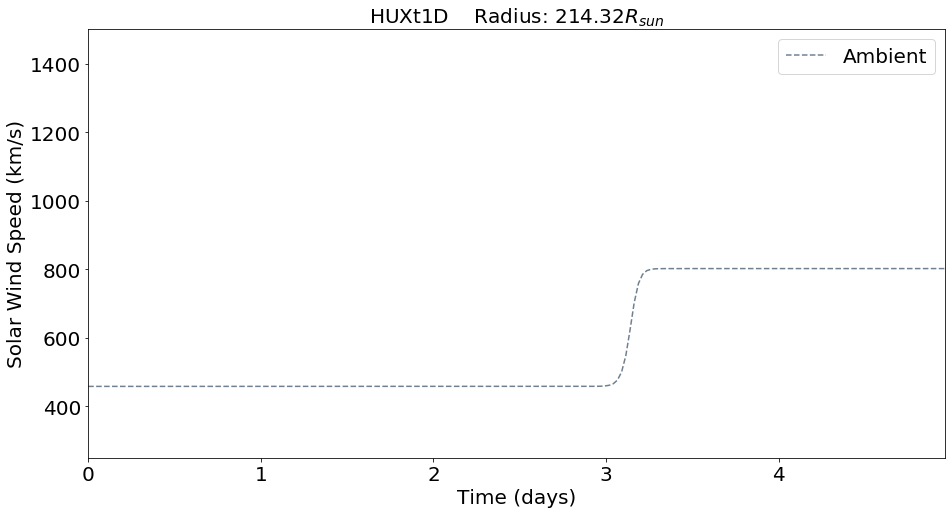

In [2]:
# Run HUXt1D with user specified boundary conditions and no CMEs

#Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt1D(v_boundary=v_boundary, lon=0.0, simtime=5, dt_scale=4)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
model.plot_radial(t, 'ambient')

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
model.plot_timeseries(r, 'ambient')

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28805f60588>)

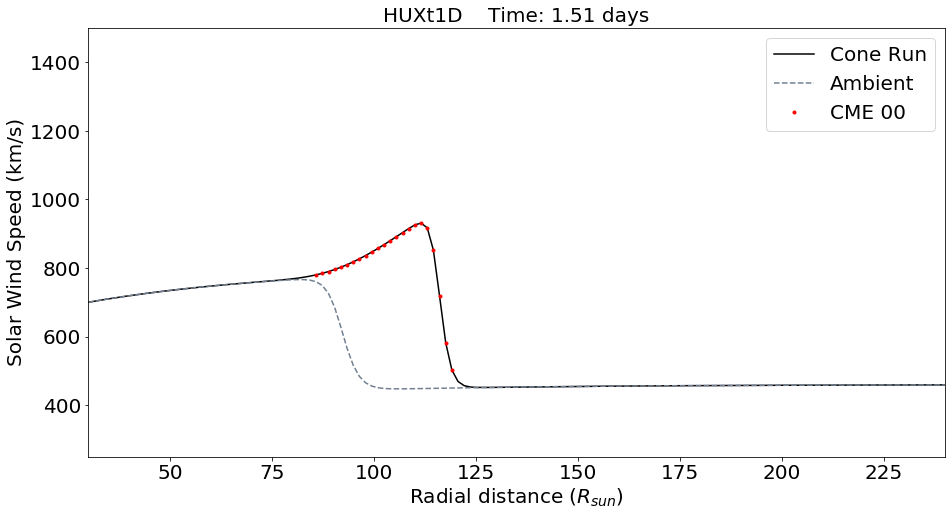

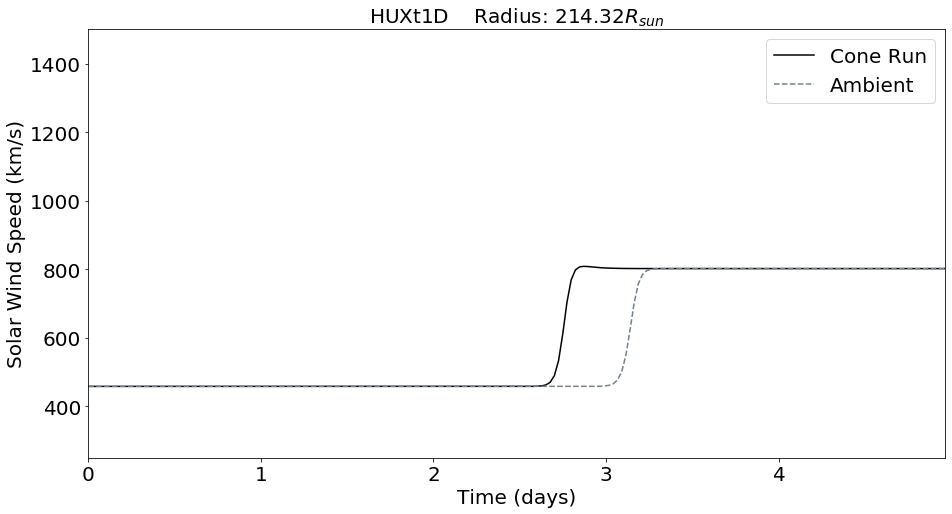

In [3]:
# Now lets run HUXt1D with the same background ambient wind and a cone cme.
# Launch the CME half a day after the simulation, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
t_launch = 0.5*u.day.to(u.s)
cme = H.ConeCME(t_launch=t_launch, longitude=0.0, width=30, v=1000, thickness=5)
cme_list = [cme]

# Run the model, and this time save the results to file. 
model.solve(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 1.5*u.day
model.plot_radial(t, 'both', save=True, tag='1d_cone_test_radial')

r = 1.0*u.AU
model.plot_timeseries(r, 'both', tag='1d_cone_test_radial')

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28806351eb8>)

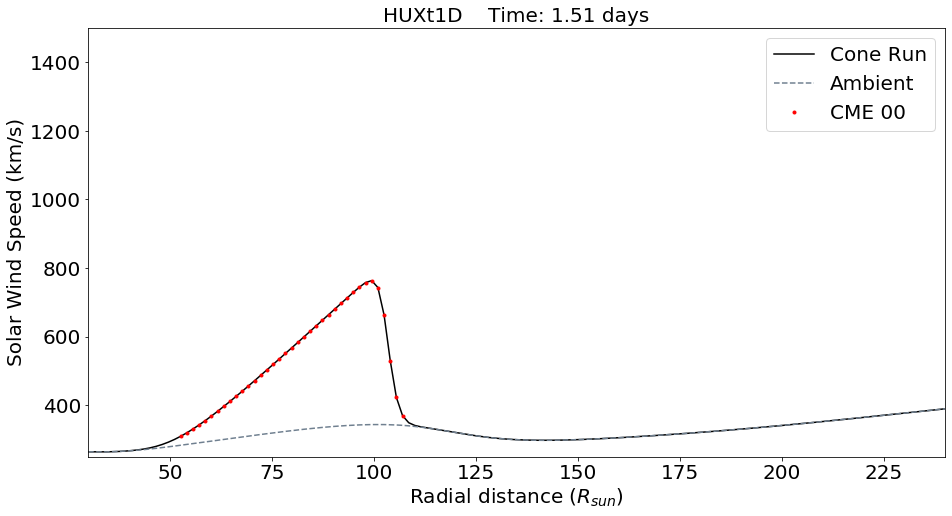

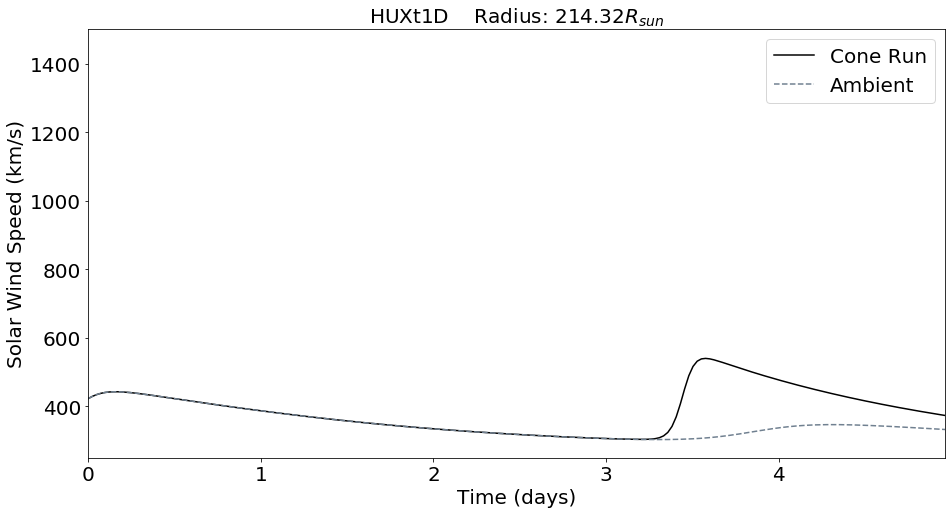

In [4]:
# We could also use boundary condtions derived from HelioMAS simulations of a Carrington rotation. 
cr_num = 2100 #This was in August 2010
model = H.HUXt1D(cr_num=cr_num, lon=0.0, simtime=5, dt_scale=4)

# Solve this with the ConeCME used in the last simulation.
model.solve(cme_list)

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well.
t = 1.5*u.day
model.plot_radial(t, 'both')

r = 1.0*u.AU
model.plot_timeseries(r, 'both')

In [5]:
# HUXt2D runs in a similar manner. 
#Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt2D(v_boundary=v_boundary, simtime=5, dt_scale=4)

model.solve(cme_list) # This takes a minute or so to run. 


(<Figure size 1008x1008 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x288072759b0>)

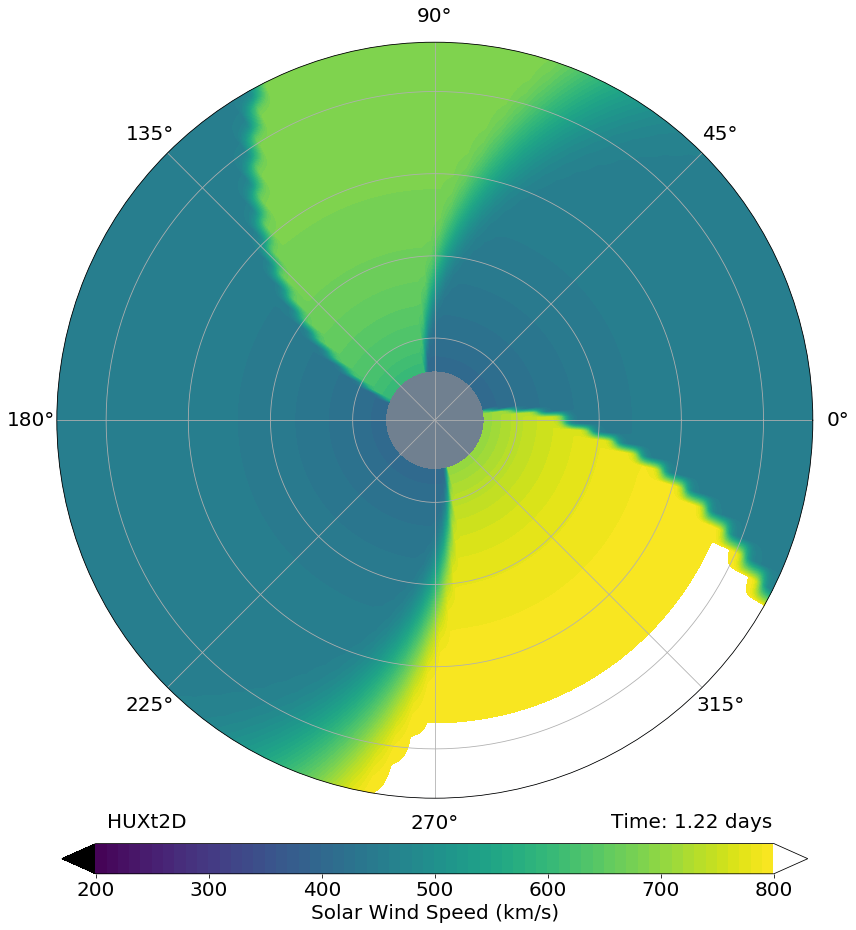

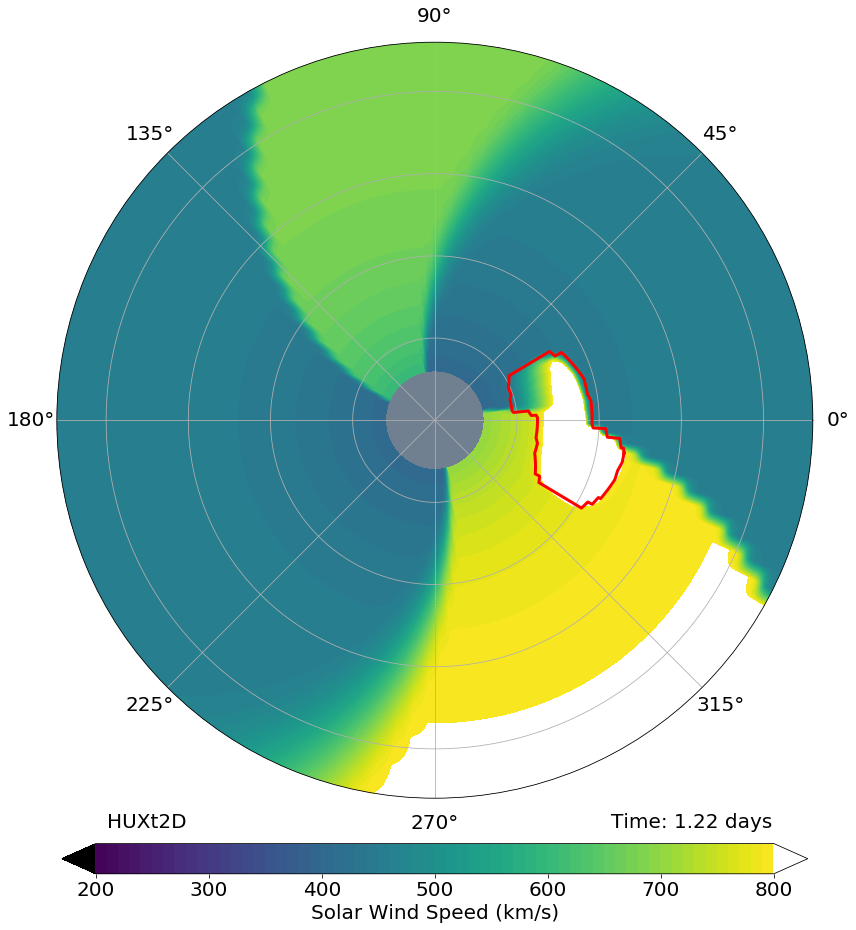

In [6]:
# Plot out the model at a specific time step for the ambient and ConeCME solutions.
model.plot(50, 'ambient')
model.plot(50, 'cme')

In [7]:
# Animate a MP4 of the CME solution. These are saved in HUXt>figures>HUXt2D
model.animate('cme', tag='cone_cme_test') # This takes about a minute too.

t:   1%|▌                                                                    | 2/240 [00:00<00:20, 11.78it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cone_cme_test_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cone_cme_test_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cone_cme_test_movie.mp4


In [8]:
# Model results can also be saved outside of the solve method.
out_path = model.save(tag='cone_cme_test')

# And loaded back in with
model2, cme_list2 = H.load_HUXt2D_run(out_path)

Text(0, 0.5, 'Y ($R_{sun}$)')

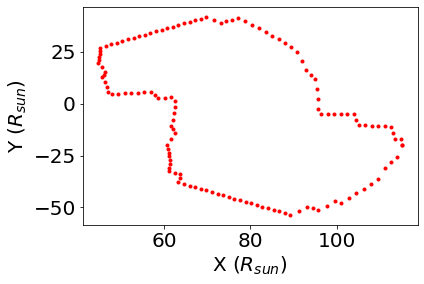

In [9]:
# If you want to get at the coordinates of the tracked CME boundary you can like.
cme = model2.cmes[0]
timestep = 50
rad = cme.coords[timestep]['r']
lon = cme.coords[timestep]['lon']
x = rad * np.cos(lon)
y = rad * np.sin(lon)

fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(x,y,'r.')
ax.set_xlabel('X ($R_{sun}$)')
ax.set_ylabel('Y ($R_{sun}$)')

In [10]:
#Both HUXt1D and HUXt2D can be run with multiple ConeCMEs.
# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt2D(cr_num=2100, simtime=5, dt_scale=4)

daysec = 86400
times = [0.5*daysec, 1.5*daysec, 3*daysec]
speeds = [850, 1000, 700]
lons = [0, 90, 300]
widths = [30, 40, 20]
thickness = [5, 4, 2]
cme_list = []
for time, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=time, longitude=l, width=w, v=v, thickness=thick)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 
model.animate('cme', tag='multi_cones')

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2100_multi_cones_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2100_multi_cones_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2100_multi_cones_movie.mp4


In [11]:
# Most of the model parameters are attributes of the HUXt1D(2D) classes, so can be accessed like:

# Model time step from the CFL condition:
print(model.dt)
# Output model time step
print(model.dt_out)

# A list of all attributes is in the documentation
help(model)

525.5287769784173 s
2102.1151079136694 s
Help on HUXt2D in module HUXt object:

class HUXt2D(builtins.object)
 |  HUXt2D(v_boundary=None, cr_num=None, simtime=5.0, dt_scale=1.0)
 |  
 |  A class containing the 2D HUXt model described in Owens et al. (2020).
 |  
 |  Users must specify the solar wind speed boundary condition through either the v_boundary, or cr_num keyword
 |  arguments. Failure to do so defaults to a 400 km/s boundary. v_boundary takes precedence over cr_num, so specifying
 |  both results in only v_boundary being used.
 |  
 |  Attributes:
 |      cmes: A list of ConeCME instances used in the model solution.
 |      cr_num: If provided, this gives the Carrington rotation number of the selected period, else 9999.
 |      daysec: seconds in a day.
 |      dlon: Longitudinal grid spacing (in radians)
 |      dr: Radial grid spacing (in km).
 |      dt: Model time step (in seconds), set by the CFL condition with v_max and dr.
 |      dt_out: Output model time step (in sec